# Iniciar Sessão Spark

import os
## Set up environment variables
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
os.environ['SPARK_HOME'] = r'C:\Users\kawda\Downloads\spark-3.5.4-bin-hadoop3\spark-3.5.4-bin-hadoop3'

## Initialize a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
	.master("local[*]") \
	.config("spark.executor.memory", "8g") \
	.config("spark.driver.memory", "8g") \
	.getOrCreate()

## Verify the Spark session
spark()

# Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import Counter
from boruta import BorutaPy

# Dados

In [76]:
# Abrir os dados disponíveis sobre o titanic
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_survived = pd.read_csv("gender_submission.csv")

# Display the first few rows of each dataframe
df_test.head()
df_train.head()
df_survived.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [77]:
# Verificar os dados
lista_spec = ['PassengerId', 'Survived']
abt_00 = df_train.drop(columns=lista_spec)

abt_00.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [78]:
# Extrair títulos usando expressão regular
abt_00['Titulo'] = abt_00['Name'].str.extract(r' (Mr\.|Miss\.|Mrs\.|Dr\.) ')
abt_00.drop(axis=1, columns='Name', inplace=True)
abt_00.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.


# Data Preparation

## Tratamento inicial padrão (Alta porcentagem de nulos, Variáveis constantes, Missings)

In [79]:
import pandas as pd
from scipy import stats

def get_metadata(dataframe):
	# Coleta de metadados básicos
	metadata = pd.DataFrame({
		'nome_variavel': dataframe.columns,
		'tipo': dataframe.dtypes,
		'qt_nulos': dataframe.isnull().sum(),
		'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
		'cardinalidade': dataframe.nunique(),
	})

	# Função para testar normalidade usando o teste de Shapiro-Wilk
	def test_normality(series, alpha=0.05):
		if series.dtype in ["float64", "int64", "int32"]:
			statistic, p_value = stats.shapiro(series.dropna())  # dropping NA values for the test
			return p_value > alpha
		else:
			return None  # Return None for non-numeric data types

	# Aplicando teste de normalidade
	metadata["fl_normal"] = dataframe.apply(test_normality)

	metadata = metadata.sort_values(by='percent_nulos', ascending=False)
	metadata = metadata.reset_index(drop=True)

	return metadata

# Apply the function to the dataframe
metadados = get_metadata(abt_00)
metadados.head()

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,fl_normal
0,Cabin,object,687,77.10,147,None
1,Age,float64,177,19.87,88,False
2,Titulo,object,60,6.73,4,None
3,Embarked,object,2,0.22,3,None
4,Pclass,int64,0,0.00,3,False


In [80]:
def preprocess_dataframe(df):
	# Drop columns with >80% missing values
	total_count = len(df)
	columns_to_drop = [col for col in df.columns if df[col].isnull().sum() / total_count > 0.8]
	df = df.drop(columns=columns_to_drop)
	
	# Replace missing values
	for col_name in df.columns:
		data_type = df[col_name].dtype
		
		if np.issubdtype(data_type, np.number):
			mean_value = df[col_name].mean()
			df[col_name] = df[col_name].fillna(mean_value)
		elif data_type == object:
			df[col_name] = df[col_name].fillna("Desconhecido")
	
	# Drop columns with variance equals to 0
	numeric_columns = df.select_dtypes(include=[np.number]).columns
	variances = df[numeric_columns].var()
	columns_to_drop = variances[variances == 0].index.tolist()
	df = df.drop(columns=columns_to_drop)
	
	return df

# Apply the function to the dataframe
abt_01 = preprocess_dataframe(abt_00)
abt_01.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,3,male,22.0,1,0,A/5 21171,7.2500,Desconhecido,S,Mr.
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Desconhecido,S,Miss.
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,3,male,35.0,0,0,373450,8.0500,Desconhecido,S,Mr.


## Tratamento de variáveis numéricas (Padronização)

In [81]:
# Instanciando o scaler
scaler = StandardScaler()

# Selecionando colunas numéricas
numeric_cols = abt_01.select_dtypes(include=['float64', 'int64','int32']).columns

# Aplicando a normalização
abt_01[numeric_cols] = scaler.fit_transform(abt_01[numeric_cols])

# Show the result
abt_01.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
0,0.827377,male,-0.592481,0.432793,-0.473674,A/5 21171,-0.502445,Desconhecido,S,Mr.
1,-1.566107,female,0.638789,0.432793,-0.473674,PC 17599,0.786845,C85,C,Mrs.
2,0.827377,female,-0.284663,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,Desconhecido,S,Miss.
3,-1.566107,female,0.407926,0.432793,-0.473674,113803,0.420730,C123,S,Mrs.
4,0.827377,male,0.407926,-0.474545,-0.473674,373450,-0.486337,Desconhecido,S,Mr.


## Tratamento de variáveis categóricas

### Baixa Cardinalidade (Dummy)

In [82]:
card_cutoff = 5
df_categ_onehot = metadados[(metadados['cardinalidade'] <= card_cutoff) & (metadados['tipo'] == 'object')]
lista_onehot = list(df_categ_onehot.nome_variavel.values)
print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(abt_01[lista_onehot])

# Criando um DataFrame com as colunas codificadas, mantendo o índice original
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=abt_01.index)

# Concatenando o DataFrame codificado com o DataFrame original
abt_01 = pd.concat([abt_01.drop(lista_onehot, axis=1), encoded_df], axis=1)

abt_01.head()


Lista de vars para OneHot Encoding:  ['Titulo', 'Embarked', 'Sex']


,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male
0,0.827377,-0.592481,0.432793,-0.473674,A/5 21171,-0.502445,Desconhecido,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,PC 17599,0.786845,C85,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,Desconhecido,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,113803,0.420730,C123,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,373450,-0.486337,Desconhecido,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Alta Cardinalidade (Label Encoding)

In [83]:
card_cutoff = 5
df_categ_labelenc = metadados[(metadados['cardinalidade'] > card_cutoff) & (metadados['tipo'] == 'object')]
lista_lenc = list(df_categ_labelenc.nome_variavel.values)
print('Lista de vars para Label Encoding: ',lista_lenc)

# Aplicando LabelEncoder nas colunas desejadas
for col in lista_lenc:
    encoder = LabelEncoder()
    abt_01[col] = encoder.fit_transform(abt_01[col])

abt_01.head()


Lista de vars para Label Encoding:  ['Cabin', 'Ticket']


,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Juntar os dados sensíveis

In [84]:
# Inner join usando o índice
abt_model = pd.merge(abt_01, df_train[['Survived']], left_index=True, right_index=True, how='inner')
abt_model.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male,Survived
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


# Métodos de seleção de variáveis

## Feature Importance

In [85]:
# Cópia para FI
abt_fi = abt_model.copy()
abt_fi.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male,Survived
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


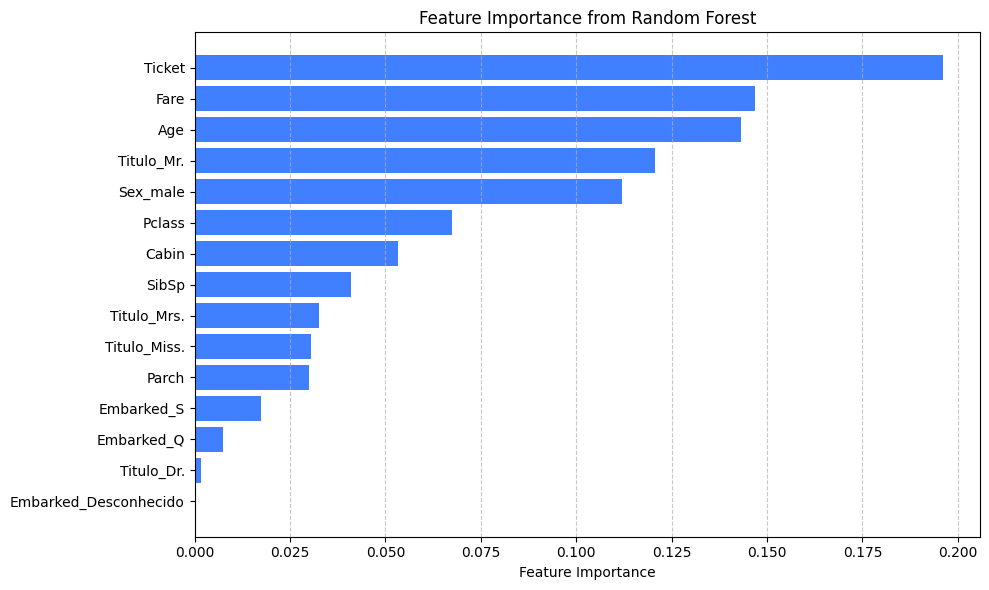

In [86]:
X = abt_fi.drop(axis=1, columns='Survived')
y = abt_fi.Survived

# Treinar modelo com algoritmo Random Forest (Calma, não precisa focar no modelo neste momento)
clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.6

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
selected_features
# Visualizando a importância das variáveis em barras horizontais

plt.figure(figsize=(10, 6))
sorted_idx = feature_importances.argsort()

plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color=(0.25, 0.5, 1))  # tom de azul claro
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [87]:
# Mantendo somente as variáveis selecionadas na ABT
abt_02 = abt_fi[selected_features + ['Survived']]

abt_02.head()

,Age,Ticket,Fare,Titulo_Mr.,Survived
0,-0.592481,523,-0.502445,1.0,0
1,0.638789,596,0.786845,0.0,1
2,-0.284663,669,-0.488854,0.0,1
3,0.407926,49,0.420730,0.0,1
4,0.407926,472,-0.486337,1.0,0


## Recursive Feature Elimination (RFE)

In [88]:
# Cópia para RFE
abt_rfe = abt_model.copy()
abt_rfe.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Titulo_Dr.,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_Desconhecido,Embarked_Q,Embarked_S,Sex_male,Survived
0,0.827377,-0.592481,0.432793,-0.473674,523,-0.502445,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,596,0.786845,81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,669,-0.488854,115,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,-1.566107,0.407926,0.432793,-0.473674,49,0.420730,55,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,-0.473674,472,-0.486337,115,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0


In [101]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_rfe = abt_rfe.drop(columns=['Survived'])
y_rfe = abt_rfe['Survived']

# Instanciar o modelo de regressão logística com mais iterações
model = LogisticRegression(max_iter=2000)

# Instanciar o RFE com o modelo e o número desejado de features
rfe = RFE(estimator=model, n_features_to_select=5)

# Ajustar o RFE aos dados
rfe = rfe.fit(X_rfe, y_rfe)

# Obter as variáveis selecionadas
selected_features_rfe = X_rfe.columns[rfe.support_].tolist()
print('Selected features by RFE:', selected_features_rfe)

# Criar um novo dataframe com as variáveis selecionadas
abt_rfe_selected = abt_rfe[selected_features_rfe + ['Survived']]
abt_rfe_selected.head()

Selected features by RFE: ['Pclass', 'SibSp', 'Titulo_Dr.', 'Titulo_Mr.', 'Sex_male']


,Pclass,SibSp,Titulo_Dr.,Titulo_Mr.,Sex_male,Survived
0,0.827377,0.432793,0.0,1.0,1.0,0
1,-1.566107,0.432793,0.0,0.0,0.0,1
2,0.827377,-0.474545,0.0,0.0,0.0,1
3,-1.566107,0.432793,0.0,0.0,0.0,1
4,0.827377,-0.474545,0.0,1.0,1.0,0


## Boruta

In [90]:
# Cópia para Boruta
abt_boruta = abt_model.copy()

In [91]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_boruta = abt_boruta.drop(columns=['Survived'])
y_boruta = abt_boruta['Survived']

# Instanciar o modelo de Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Instanciar o Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=1)

# Ajustar o Boruta aos dados
boruta.fit(X_boruta.values, y_boruta.values)

# Obter as variáveis selecionadas
selected_features_boruta = X_boruta.columns[boruta.support_].tolist()
print('Selected features by Boruta:', selected_features_boruta)

# Criar um novo dataframe com as variáveis selecionadas
abt_boruta_selected = abt_boruta[selected_features_boruta + ['Survived']]
abt_boruta_selected.head()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	5
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	5
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	5
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	5
Iteration:

,Pclass,Age,SibSp,Ticket,Fare,Cabin,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Sex_male,Survived
0,0.827377,-0.592481,0.432793,523,-0.502445,115,0.0,1.0,0.0,1.0,0
1,-1.566107,0.638789,0.432793,596,0.786845,81,0.0,0.0,1.0,0.0,1
2,0.827377,-0.284663,-0.474545,669,-0.488854,115,1.0,0.0,0.0,0.0,1
3,-1.566107,0.407926,0.432793,49,0.420730,55,0.0,0.0,1.0,0.0,1
4,0.827377,0.407926,-0.474545,472,-0.486337,115,0.0,1.0,0.0,1.0,0


## Pearson Correlation

In [92]:
# Cópia para Pearson
abt_pearson = abt_model.copy()

In [ ]:
# Calcular a correlação de Pearson entre as features e a variável alvo
correlation_matrix = abt_pearson.corr()

# Selecionar as features que possuem uma correlação significativa com a variável alvo
correlation_threshold = 0.1  # Defina um limiar de correlação
significant_features = correlation_matrix.index[abs(correlation_matrix["Survived"]) > correlation_threshold].tolist()

# Remover a variável alvo da lista de features significativas
significant_features.remove("Survived")

# Criar um novo dataframe com as features selecionadas
abt_pearson_selected = abt_pearson[significant_features + ["Survived"]]

print("Selected feature by Pearson:", significant_features)

# Exibir as primeiras linhas do novo dataframe
abt_pearson_selected.head()

Variáveis selecionadas pela correlação de Pearson: ['Pclass', 'Ticket', 'Fare', 'Cabin', 'Titulo_Miss.', 'Titulo_Mr.', 'Titulo_Mrs.', 'Embarked_S', 'Sex_male']


,Pclass,Ticket,Fare,Cabin,Titulo_Miss.,Titulo_Mr.,Titulo_Mrs.,Embarked_S,Sex_male,Survived
0,0.827377,523,-0.502445,115,0.0,1.0,0.0,1.0,1.0,0
1,-1.566107,596,0.786845,81,0.0,0.0,1.0,0.0,0.0,1
2,0.827377,669,-0.488854,115,1.0,0.0,0.0,1.0,0.0,1
3,-1.566107,49,0.420730,55,0.0,0.0,1.0,1.0,0.0,1
4,0.827377,472,-0.486337,115,0.0,1.0,0.0,1.0,1.0,0


## Corte por IV

In [94]:
# Cópia para IV
abt_iv = abt_model.copy()

In [95]:
def calculate_iv(df, feature, target, bins=10):
	"""
	Função para calcular o Information Value (IV) de uma variável.
	"""
	df = df[[feature, target]].copy()
	df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
	grouped = df.groupby('bin', observed=False)[target].agg(['count', 'sum'])
	grouped['non_event'] = grouped['count'] - grouped['sum']
	grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
	grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
	grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
	grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
	iv = grouped['iv'].sum()
	return iv

# Calcular o IV para cada variável
iv_values = {}
target = 'Survived'
for feature in abt_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_iv, feature, target)
		iv_values[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > iv_threshold]
print('Selected features by IV:', selected_features_iv)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_selected = abt_iv[selected_features_iv + [target]]
abt_iv_selected.head()

Selected features by IV: ['Pclass', 'Age', 'Ticket', 'Fare', 'Cabin']


,Pclass,Age,Ticket,Fare,Cabin,Survived
0,0.827377,-0.592481,523,-0.502445,115,0
1,-1.566107,0.638789,596,0.786845,81,1
2,0.827377,-0.284663,669,-0.488854,115,1
3,-1.566107,0.407926,49,0.420730,55,1
4,0.827377,0.407926,472,-0.486337,115,0


## PCA + IV

In [96]:
# Cópia para PCA+IV
abt_pca_iv = abt_model.copy()

In [97]:
# Calcular o IV para cada variável
iv_values_pca = {}
target = 'Survived'
for feature in abt_pca_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_pca_iv, feature, target)
		iv_values_pca[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold_pca = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv_pca = [feature for feature, iv in iv_values_pca.items() if iv > iv_threshold_pca]
print('Selected features by IV:', selected_features_iv_pca)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_pca_selected = abt_pca_iv[selected_features_iv_pca]

# Separar as variáveis independentes (X) e a variável dependente (y)
X_iv_pca = abt_iv_pca_selected
y_iv_pca = abt_pca_iv[target]

# Aplicar PCA
pca = PCA(n_components=5)  # Defina o número de componentes principais desejado
X_pca = pca.fit_transform(X_iv_pca)

# Criar um novo dataframe com as componentes principais
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
abt_pca_iv_selected = pd.DataFrame(X_pca, columns=pca_columns)
abt_pca_iv_selected[target] = y_iv_pca.values

# Exibir as primeiras linhas do novo dataframe
abt_pca_iv_selected.head()

Selected features by IV: ['Pclass', 'Age', 'Ticket', 'Fare', 'Cabin']


,PC1,PC2,PC3,PC4,PC5,Survived
0,184.646392,3.845738,-0.794526,0.017955,-0.005003,0
1,256.684567,-32.207691,1.186250,-0.094852,-0.793980,1
2,330.591455,-0.154354,-0.520097,0.250870,-0.063654,1
3,-290.821115,-43.202515,-0.075178,0.181075,-0.391357,1
4,133.665198,5.234176,-0.167688,0.717650,0.324558,0


# Comparação das técnicas

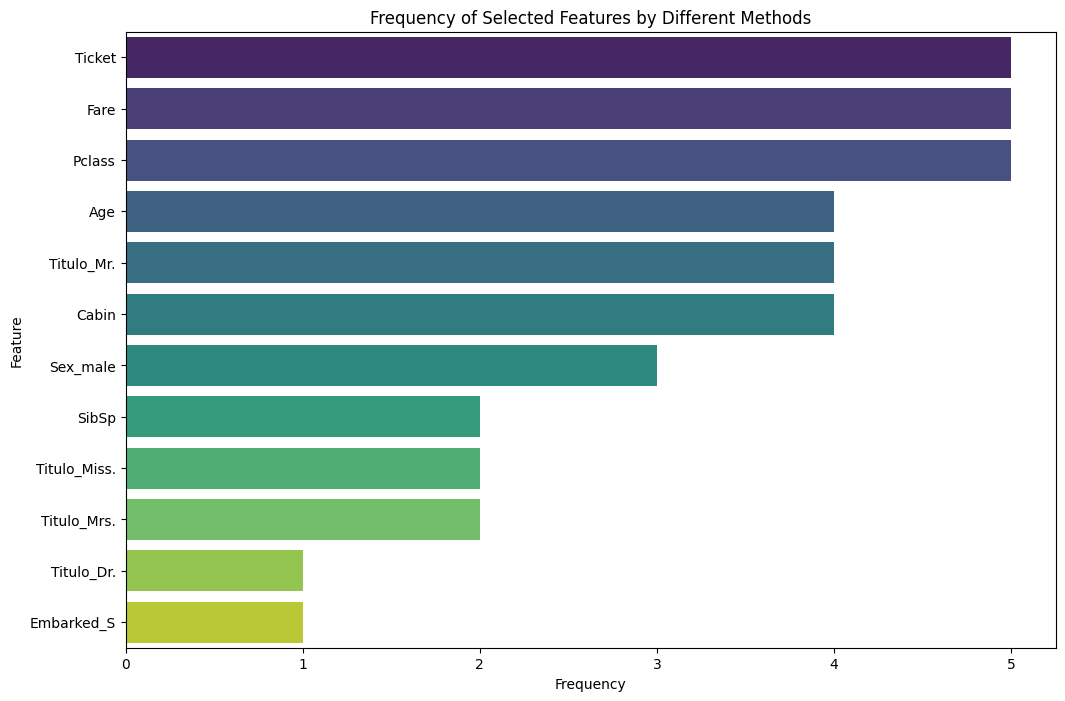

Boruta: 5
Feature Importance: 4
IV: 4
Pearson: 4
PCA + IV: 4
RFE: 2


In [100]:
# Variáveis selecionadas por cada método
selected_features_dict = {
	'Feature Importance': selected_features,
	'RFE': selected_features_rfe,
	'Boruta': selected_features_boruta,
	'IV': selected_features_iv,
	'Pearson': significant_features,
	'PCA + IV': selected_features_iv_pca
}

# Contar a frequência de cada variável
all_selected_features = [feature for features in selected_features_dict.values() for feature in features]
feature_counts = Counter(all_selected_features)

# Criar um DataFrame para facilitar a visualização
feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency']).reset_index()
feature_counts_df.columns = ['Feature', 'Frequency']

# Plotar o histograma de frequência
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df.sort_values(by='Frequency', ascending=False), x='Frequency', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Frequency of Selected Features by Different Methods')
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.show()

# Listar as técnicas em ordem de qual selecionou o maior número do top 5 de variáveis mais selecionadas
top_5_features = feature_counts_df.sort_values(by='Frequency', ascending=False).head(5)['Feature'].tolist()
technique_counts = {technique: len(set(features) & set(top_5_features)) for technique, features in selected_features_dict.items()}
sorted_techniques = sorted(technique_counts.items(), key=lambda item: item[1], reverse=True)

# Exibir a lista em ordem
for technique, count in sorted_techniques:
	print(f"{technique}: {count}")


Temos aqui uma comparação de quais variáveis foram escolhidas e quantas vezes por cada técnica, assim temos uma "opnião diferente" para quais variáveis são realmente relevantes para o comportamento do Target, nesse caso a sobrevivência dos tripulantes. Além disso, abaixo do gráfico há quais técnicas de feature selection selecionaram o top-5 das variáveis escolhidas, indicando boas técnicas para serem utilizadas.